# Notebook 4: Text Features and Model Fits

David Tersegno


3/29/22

This notebook takes the text-heavy features, the post titles and body texts, and applies a (1,3) count vectorizer. This creates a new feature for every word, sequence of two words, and sequence of three words that shows at least twice in the text. These will end up constituting the real bulk of the feature set.

After that, the data is train-test-split, fit, scored, and predicted on several `sklearn` default models. A DecisionTreeClassifier is picked as the best model, with perfect accuracy given this training and test data.

Some implications of the model are discussed, as well as suggestions for future steps.

In [56]:
#import libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#sklearn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

plt.style.use('dark_background')

In [57]:
#import number-treated data
df = pd.read_csv('./data_clean_num/data_clean_num.csv')

#take a look at the basics of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 420 entries, Unnamed: 0 to subreddit_lua
dtypes: bool(5), float64(387), int64(26), object(2)
memory usage: 9.5+ MB


In [58]:
#no null values inherited  - the last notebook dealt with them.
df.isnull().sum().sum()

0

In [59]:
#look at the columns
df.columns

Index(['Unnamed: 0', 'is_crosspostable', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'score',
       'selftext', 'title', 'upvote_ratio',
       ...
       'crosspost_subreddit_lambdachip', 'crosspost_subreddit_linux_gaming',
       'crosspost_subreddit_manool', 'crosspost_subreddit_sbcl',
       'crosspost_subreddit_scheme', 'crosspost_subreddit_sicp',
       'crosspost_subreddit_stumpwm', 'subreddit_haskell', 'subreddit_lisp',
       'subreddit_lua'],
      dtype='object', length=420)

---
# Remove lua data.

We will perform a binary classification between haskell and lisp subreddit posts.

In [60]:
#grab observations with subreddit_haskell or subreddit_lisp ==1 
df =df[ (df['subreddit_haskell'] == 1) |( df['subreddit_lisp'] == 1) ]

#ensure there are 1000 of both classes.
len(df)

2000

---
# Count Vectorizer

I needed [this stack overflow answer](https://stackoverflow.com/questions/38256104/differences-between-merge-and-concat-in-pandas#:~:text=axis%20while%20concatenating.-,pd.,DataFrame%20s%20with%20different%20indices.) to sort out the difference between `.join()`, `.merge()`, and `.concat()`.

I will use `.join()` to combine DataFrames with respect to index.

In [61]:
#instantiate a count vectorizer
cvec = CountVectorizer(min_df=2, ngram_range=(1,3), stop_words='english')

# count vectorize text data and make it a new dataframe
X_cvec_text = cvec.fit_transform(df['selftext'])
X_cvec_text_df = pd.DataFrame(X_cvec_text.todense(), columns = cvec.get_feature_names())

# count vectorize title data and make it a new dataframe
X_cvec_title = cvec.fit_transform(df['title'])
X_cvec_title_df = pd.DataFrame(X_cvec_title.todense(), columns = cvec.get_feature_names())

# join dataframes (add all newly created features to the data)
X = pd.concat([df, X_cvec_title_df],  axis = 1)
X = pd.concat([X, X_cvec_text_df] ,  axis = 1 )
X

,Unnamed: 0,is_crosspostable,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,score,selftext,title,upvote_ratio,...,youtube,youtube channel,youtube com,youtube com channel,youtube com watch,ys,yy,zero,zip,zsh
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995.0,False,False,False,False,True,1.0,[removed],Why Common Lisp is powerful language for AI?,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2996,2996.0,True,False,False,True,False,1.0,0,Clojure’s super bowl debut?,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2997,2997.0,True,False,False,True,False,1.0,0,CLiki: IRC Quotes,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2998,2998.0,True,False,False,True,False,1.0,0,"""Programming Algorithms in Lisp"" - HN discussi...",1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
#the lua data brought a lot of extra rows with their indices. drop them.
X = pd.DataFrame(X.loc[1000:])

In [63]:
#there are still a lot of remaining NaNs due to new dummy columns.
X.isnull().sum().sum()

13839000

In [64]:
#fill these with 0s, "false"
X.fillna(0, inplace=True)

In [65]:
#drop the redundant index column
X.drop(columns = "Unnamed: 0", inplace=True)

C:\Users\David\AppData\Local\Temp/ipykernel_14012/1483072722.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.hist(X.sum(axis=1), bins = 30);


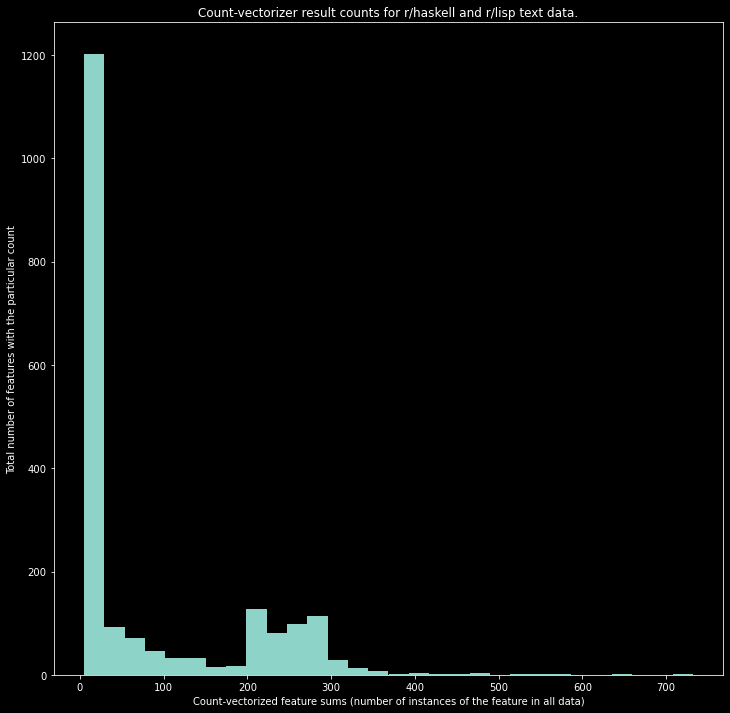

In [66]:
# look at histogram of count vectorized words.
plt.figure(figsize=(12,12))
plt.title("Count-vectorizer result counts for r/haskell and r/lisp text data.")
plt.xlabel('Count-vectorized feature sums (number of instances of the feature in all data)')
plt.ylabel('Total number of features with the particular count')
plt.hist(X.sum(axis=1), bins = 30);

It looks like there are a huge number of low values, but a hill of common values in the 200s. These values may be important for classification models.

In [69]:
# remove selftext and title from the data. They've been count vectorized already.
X.drop(columns=['selftext', 'title'], inplace=True)

In [70]:
#there were 420 columns in the original imported dataframe --- all new count vectorized columns
# are after this.


# get the most common words. That's adding all the entries in a column.
common_words = X[ X.columns[420:]].apply(lambda x: sum(x.astype('int')))

In [71]:
#There are lots of features now.
len(common_words)

16773

In [72]:
#list most common words in the set.
common_words.sort_values()[-50:]

file                 95
ve                   99
ve                   99
time                113
time                113
function            122
function            122
removed             123
list                133
list                133
using               134
using               134
https github com    141
https github        141
https github        141
https github com    141
just                142
just                142
github com          146
github com          146
common lisp         150
common lisp         150
common              153
common              153
gt                  170
gt                  170
use                 171
use                 171
code                180
code                180
github              182
github              182
common lisp         196
common lisp         196
cl                  207
cl                  207
common              212
common              212
amp                 214
amp                 214
like                221
like            

In [73]:
X['subreddit_lisp'].sum()

1000.0

In [50]:
cvec_pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

pipe = Pipeline([
    ('ss', StandardScaler() ),
    ( 'mnb' , MultinomialNB() )
])




---
# Split features from target

In [51]:
#remember, ignoring lua. subreddit_haskell is our target now.

X = pd.DataFrame(X.drop(columns=['subreddit_lua','subreddit_lisp']))
y = X['subreddit_haskell']
       
X_train, x_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.25,
                                                   stratify = y,
                                                   random_state = 2023
                                                   )

In [53]:
list(X.columns)

['is_crosspostable',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'score',
 'upvote_ratio',
 'thumbnail_height',
 'thumbnail_width',
 'is_crosspost',
 'domain_/r/lua/comments/rwyabs/hello_guys_im_working_with_some_old_code_and_i/',
 'domain_/r/lua/comments/t4q8hg/im_making_a_real_attack_roblox_game_and_my/',
 'domain_12chip.com',
 'domain_88cc.ru',
 'domain_adhdcollegesuccess.com',
 'domain_agulev.com',
 'domain_andregarzia.com',
 'domain_andreyorst.gitlab.io',
 'domain_bangkoknightlife.com',
 'domain_blog.coursesity.com',
 'domain_cabancondosmexico.com',
 'domain_casamento.xyz',
 'domain_christianzink.medium.com',
 'domain_codeproject.com',
 'domain_crimescenecleanup247.com',
 'domain_developereconomics.net',
 'domain_direct-link.net',
 'domain_dzone.com',
 'domain_emergenie.co.uk',
 'domain_emilua.gitlab.io',
 'domain_energyoutlet.com',
 'domain_ferib.dev',
 'domain_getajobalabama.com',
 'domain_gist.github.com',
 'domain_github.blog',
 'doma

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, stratify = y, test_size = 0.33)

## Apply Models

### MultinomialNaiveBayes

Wall time: 5.2 s


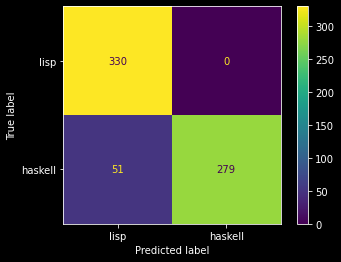

In [215]:
%%time
mnb = MultinomialNB()
mnb.fit(X_train, y_train)


plot_confusion_matrix(mnb, X_test, y_test, display_labels=('lisp', 'haskell'))

In [220]:
mnb.score(X_train,y_train), mnb.score(X_test,y_test)

(0.9216417910447762, 0.9227272727272727)

In [216]:
preds = mnb.predict(X_test)

In [217]:
accuracy_score(y_test, preds)

0.9227272727272727

In [218]:
recall_score(y_test, preds)

0.8454545454545455

In [219]:
precision_score(y_test, preds)

1.0

This model fit quickly and is nicely accurate.

### DecisionTreeClassifier

Wall time: 2.51 s


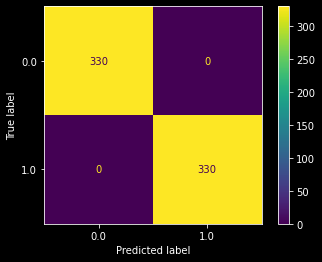

In [221]:
%%time
# do the same with other classifiers.
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
plot_confusion_matrix(dtc, X_test, y_test);

In [222]:
dtc.score(X_train, y_train), dtc.score(X_test, y_test)

(1.0, 1.0)

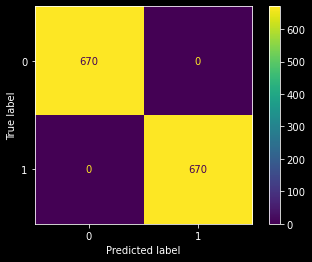

In [298]:
plot_confusion_matrix(dtc, X_train, y_train);

In [229]:
#time a prediction
%%time
dtc.predict(X_test);

Wall time: 752 ms


array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0.

In [230]:
#time per observation in milliseconds
752/len(X_test)

1.1393939393939394

This model performed exceptionally well. Every object was correctly classified in both the training and test sets.

### ExtraTreesClassifier

In [300]:
etc = ExtraTreeClassifier()
etc.fit(X_train, y_train)
etc.score(X_train, y_train), etc.score(X_test, y_test)


(1.0, 0.996969696969697)

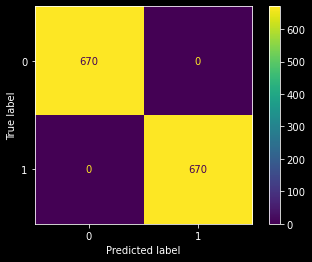

In [301]:
plot_confusion_matrix(etc, X_train, y_train)

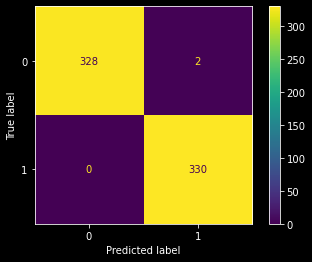

In [302]:
plot_confusion_matrix(etc, X_test, y_test)

Not quite as good as the DecisionTreeClassifier, but almost perfect. Only two of 660 observations in the test set misclassified. 

### SVC

In [324]:
%%time

svc = SVC()
svc.fit(X_train, y_train)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

svc.score(Xs_train,y_train), svc.score(Xs_test, y_test)

Wall time: 17.9 s


(0.5044776119402985, 0.5045454545454545)

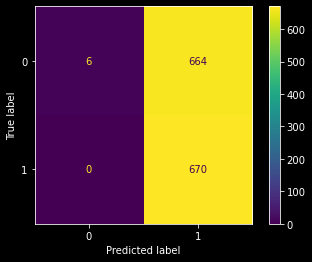

In [325]:
#The default SVC performed quite poorly!
plot_confusion_matrix(svc, Xs_train, y_train)

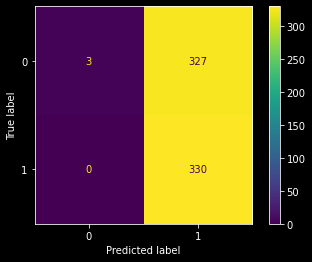

In [326]:
plot_confusion_matrix(svc, Xs_test, y_test)

This one performed terribly. We started with balanced classes, implying a baseline accuracy of 0.50. This one almost universally picks haskell over lisp.

### LogRegCV

Takes a little while to fit, but not even a minute.

In [224]:
%%time
lr = LogisticRegressionCV(max_iter=5_000_000, n_jobs=-1)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

lr.fit(Xs_train, y_train)
lr.score(Xs_train, y_train), lr.score(Xs_test, y_test)

Wall time: 36.8 s


(1.0, 0.996969696969697)

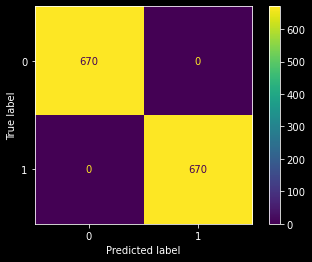

In [312]:
plot_confusion_matrix(lr, X_train, y_train)

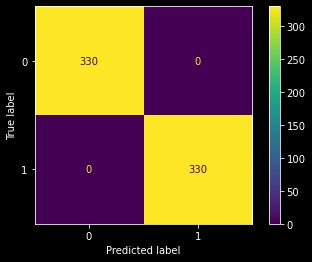

In [313]:
plot_confusion_matrix(lr, X_test, y_test)

In [ ]:
Those scores are almost perfect.

### RandomForest

In [225]:
%%time
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_test, y_test)

Wall time: 6.83 s


(1.0, 1.0)

Perfect accuracy. This still takes nearly three times as long as the DecisionTreeClassifier.

---
---
# Model Selection
---
The sklearn default DecisionTreeClassifier() performed with perfect accuracy on the data.
In the short term, I would be confident in applying this to new r/haskell and r/lisp posts and getting a correct classification.

The problem is, it is catching a lot of instances of the word 'lisp' within the texts. The decision tree is likely dividing the data based on these right away, with the first few branches. It would be worth the time to examine the function of the fit decision tree classifier, to confirm this. This model is likely performing very well through a kind of loophole. Removing these words and retraining would be a good start to establishing the robustness of the model.

As time progresses, even a model like this may lose its accuracy on new posts. New events and ideas in these programming communities will shape the text in Reddit posts. The culture within the subreddits may change as well. As time continues on, perhaps on a year-long time-scale, this classifier will begin to perform more poorly as it was fit on outdated language. It would need to be retrained periodically if it were to be used to classify subreddits.

---



# Future Considerations

It would be quite interesting to construct a comment tree for each post with comments based on parent-id-linking of appropriate comment data. I believe some differences in the shape and size of these trees could reveal commenting habits and conversation style differences between the subreddits, aiding in classification.

---